In [34]:
# imprt the model
from PIL import Image
import torch
model_name="openai/clip-vit-base-patch16"
from transformers import AutoProcessor, AutoModelForZeroShotImageClassification
processor = AutoProcessor.from_pretrained(model_name)
model = AutoModelForZeroShotImageClassification.from_pretrained(model_name)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)
model.eval()


CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPSdpaAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e

In [46]:
# load the data
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image
import torchvision.datasets as datasets
# Download the dataset
cifar100 = datasets.CIFAR100(root='../data', download=False, train=False)

In [47]:
print(len(cifar100))

10000


In [2]:
#text tokenization
def tokenize_text(text):
    with torch.no_grad():
        tensor = processor.tokenizer(text, return_tensors="pt", padding=True).input_ids
        proto = model.text_model(tensor.to(device))
        output = model.text_projection(proto.pooler_output)
        output = output / output.norm(dim=-1, keepdim=True)
        return output

text_features = tokenize_text(cifar100.classes)
text_features /= text_features.norm(dim=-1, keepdim=True)
import pickle
with open('text_features.pkl', 'wb') as f:
    pickle.dump(text_features, f)

NameError: name 'processor' is not defined

In [4]:
import pickle

with open('text_features.pkl', 'rb') as f:
    text_features = pickle.load(f)

In [5]:
#image tokenization and prediction
def tokenize_image(image):
    with torch.no_grad():
        tensor = processor.image_processor(images=image, return_tensors="pt").pixel_values
        proto = model.vision_model(tensor.to(device))
        output = model.visual_projection(proto.pooler_output)
        output /= output.norm(dim=-1, keepdim=True)
        return output

def get_similarity(img_outputs, txt_outputs):
    similarity = (100.0 * img_outputs @ txt_outputs.T).softmax(dim=-1)
    return similarity

def predict(data,existed_img_features=None):
    image,label=data
    if existed_img_features is not None:
        img_outputs = existed_img_features
    else:
        img_outputs = tokenize_image(image)
    txt_outputs = text_features
    similarity = get_similarity(img_outputs, txt_outputs)
    values, indices = similarity[0].topk(5)
    return label==indices[0].item(),img_outputs.cpu()
# answer,data=predict(cifar100[0])
# print(answer,data.shape)

In [ ]:
#tokenize and save ALL data,get the accuracy
from tqdm import tqdm
acc=0
save_list=[]
for i in tqdm(range(1000)):
    prediction,data=predict(cifar100[i])
    acc+=prediction
    temp=[data,cifar100[i][1]]
    save_list.append(temp)
with open('save_list.pkl', 'wb') as f:
    pickle.dump(save_list, f)
print(acc/10)

In [ ]:
predict(cifar100[0],save_list[0][0])[0]

In [1]:
import pickle
with open('mnist.pkl', 'rb') as f:
    tensor_dataset = pickle.load(f)
# train_size = int(0.8 * len(tensor_dataset))
# test_size = len(tensor_dataset) - train_size
with open('mnist_text.pkl', 'rb') as f:
    text_features = pickle.load(f)

In [6]:
import torch
from torch.utils.data import DataLoader, random_split
train_size = int(0.7 * len(tensor_dataset))
test_size = len(tensor_dataset) - train_size
torch.manual_seed(42)

# for data in tensor_dataset:
#     data[0]/=data[0].norm(dim=-1, keepdim=True)
train_dataset, test_dataset = random_split(tensor_dataset, [train_size, test_size])

In [4]:
#直接使用tensor进行测试
import tqdm
import torch

def fun1(sample_size):
    train_size = int(sample_size * len(tensor_dataset))
    test_size = len(tensor_dataset) - train_size
    train_dataset, test_dataset = random_split(tensor_dataset, [train_size, test_size])
    acc=0
    for i in range(len(test_dataset)):
        pdt,_=predict(test_dataset[i],test_dataset[i][0])
        acc+=pdt
    # print(acc/len(tensor_dataset))
    accuracy=acc/len(test_dataset)
    return accuracy
fun1(0.7)

NameError: name 'predict' is not defined

In [7]:
#knn
import torch
from sklearn.neighbors import KNeighborsClassifier
def fun2(sample_size):
    train_size = int(sample_size * len(tensor_dataset))
    test_size = len(tensor_dataset) - train_size
    train_dataset, test_dataset = random_split(tensor_dataset, [train_size, test_size])
    # 提取训练集特征和标签
    train_features = [data[0].numpy().flatten() for data in train_dataset]
    train_labels = [data[1] for data in train_dataset]

    # 创建 KNN 分类器
    knn = KNeighborsClassifier(n_neighbors=5,weights='distance')

    # 训练分类器
    knn.fit(train_features, train_labels)

    # 提取测试集特征

    test_features = [data[0].numpy().flatten() for data in test_dataset]
    test_labels = [data[1] for data in test_dataset]

    # 进行预测
    predictions = knn.predict(test_features)

    correct_predictions = 0
    for true_label, predicted_label in zip(test_labels, predictions):
        if true_label == predicted_label:
            correct_predictions += 1

    accuracy = correct_predictions / len(test_labels)
    # print(f"准确率为：{accuracy}")
    return accuracy
fun2(0.7)

0.92

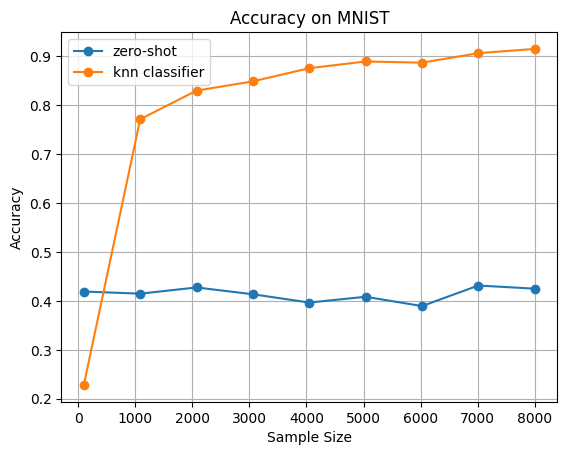

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# 定义样本量范围
sample_sizes = np.linspace(0.01, 0.8, 9)

# 计算fun1和fun2在不同样本量下的准确率
accuracies_fun1 = [fun1(sample_size) for sample_size in sample_sizes]
accuracies_fun2 = [fun2(sample_size) for sample_size in sample_sizes]

# 绘制折线图
plt.plot(sample_sizes*10000, accuracies_fun1, label='zero-shot', marker='o')
plt.plot(sample_sizes*10000, accuracies_fun2, label='knn classifier', marker='o')

# 添加标题和坐标轴标签
plt.title('Accuracy on MNIST')
plt.xlabel('Sample Size')
plt.ylabel('Accuracy')
plt.grid(True)
# 添加图例
plt.legend()

# 显示图形
plt.show()

In [43]:
print(len(tensor_dataset))

10000
